# Домашнее задание курса "Прикладная математика: искусство и ремесло вычислений"

## Задача 6.1

Номер группы m=2, а номер в списке k=14, 

поэтому исходное уравнение приобретает вид: 

$u''+[2+14cos(px)]u=0$\
Запишем его в виде следующей системы:  

$
\begin{equation*}
\begin{cases}
z_{1}' = z_{2} 
\\
z_{2}' = -(2+14cos(px))z_{1}
\end{cases}
\end{equation*}
$

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sympy import Matrix
from scipy.integrate import odeint

Построим два линейно независимых численных решения, для этого сначала напишем функции которые понадобятся в ходе выполнения всех задач

In [2]:
def deffur(z, t):
    '''с помощью неё будем считать численно 
       решения системы диффуров'''
    z1, z2 = z
    return [z2, -(2+14*np.cos(p*t))*z1]

In [3]:
class Interpolation:

    def __init__(self, x_net, x_data, y_data):
        self.x_net = x_net
        self.x_data = x_data
        self.y_data = y_data

    def ermit(self, a, b, Pvals):
        '''Задает интерполяцию эрмита, на вход принимает:
          a, b - начало и конец отрезка интерполяции
          Pvals - вектор со значением в точке а, 
                        значением её производной, 
                        значением в точке b,
                        производной в точке b'''

        x = self.x_net
        Pa, dPa, Pb, dPb = Pvals
        h = b-a

        P = (dPa*(x-a)*(x-b)**2/h**2+Pa*(2*(x-a)*(x-b)**2/h**3+(x-b)**2/h**2)
            +dPb*(x-a)**2*(x-b)/h**2+Pb*(2*(x-a)**2*(b-x)/h**3+(x-a)**2/h**2))
        return P

    def splain_interp(self, border_right, border_left):
        """Считает значения кубического сплайна дефекта 1, 
          border_right, border_left - граничные условия"""
        
        x_val, y_val = self.x_data, self.y_data
        x = self.x_net

        h = np.array([])
        for i in range(x_val.shape[0]-1):
            h = np.append(h, x_val[i+1]-x_val[i])

        lam = h[1:]/(h[:-1]+h[1:])
        mu = 1-lam 
        C = (3*lam*(y_val[1:-1]-y_val[:-2])/h[:-1]
            +3*mu*(y_val[2:]-y_val[1:-1])/h[1:])
        
        A = 2*np.eye(11)+np.diag(np.append(0, mu), 1)
        A += np.diag(np.append(lam, 0), -1)
        A[0, 0] = 1
        A[10, 10] = 1

        C = np.append(np.append(border_right, C), border_left)
        m = np.matmul(np.linalg.inv(A), C)

        s = np.array([])
        for k in range(10):
            if k == 9:
                xx = x[(x >= x_val[k]) & (x <= x_val[k+1])]
            else:
                xx = x[(x >= x_val[k]) & (x < x_val[k+1])]
            s = (np.append(s, Interpolation(xx, x_val, 
                 y_val).ermit(x_val[k], x_val[k+1], [y_val[k], 
                 m[k], y_val[k+1], m[k+1]])))
        return s

    def L_polinomial(self):
        """Считает значения интерполяционного многочлена Лагранжа"""

        x_net, data, y_data = self.x_net, self.x_data, self.y_data

        # vector будет вектором с базисными полиномами
        vector = np.zeros(len(data)).tolist()
        
        for i in range(len(data)):

            sup_vec = data[data != data[i]]
            # mul это i базисный полином
            mul = 1
            for j in range(len(sup_vec)):
                mul = np.multiply(mul, (x_net-sup_vec[j])/(data[i]-sup_vec[j]))
                
            vector[i] = mul
        
        #тут из базисных полиномов делаем один итоговый
        lagrange = np.dot(y_data, vector)
        return lagrange

In [4]:
#Зададим разные параметры p для первого задания
pp = [0, 14/5, 5]

Теперь для каждого параметра p нарисуем график двух линейно независимых
                                                                        
решений, в качестве начальных условий будут векторы (1;0) и (0;4)

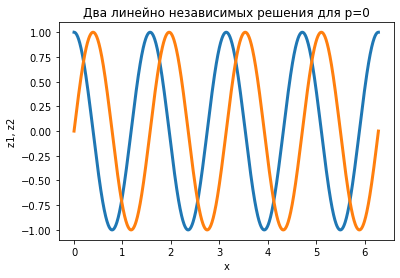

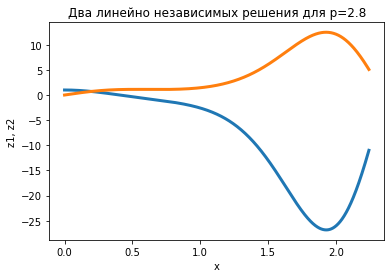

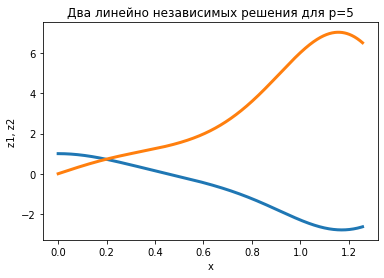

In [5]:
for p in pp:
  
    #зададим сетку
    try:
        t = np.linspace(0,2*np.pi/p,1000)
    except ZeroDivisionError:
        t = np.linspace(0,2*np.pi,1000)

    #создадим график
    fig, ax = plt.subplots()
    ax.set_xlabel('x')
    ax.set_ylabel('z1, z2')
    ax.set_title('Два линейно независимых решения для p='+str(p))

    #Начальные условия
    z0 = [[1, 0], [0, 4]]

    #Первое решение с начальными условиями 1 0
    [z_11,z_21]=odeint(deffur, z0[0], t, full_output=False).T
    ax.plot(t, z_11, linewidth=3)

    #Второе решение с начальными условиями 0 4
    [z_12,z_22]=odeint(deffur, z0[1], t, full_output=False).T
    ax.plot(t, z_12, linewidth=3)

Теперь запишем вронскиан из векторов решений например для p=0 он выглядит так

$W = \left(
\begin{array}{cccc}
cos4x & sin4x \\
-4sin4x & 4cos4x\\
\end{array}
\right)$

Нетрудно понять, что он всегда равен 4 и не меняется со временем, а $W'=0$ 

Покажу это численно при p=5 исходя из полученных в предыдущем пункте решений

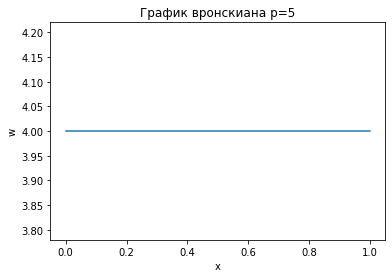

In [6]:
# Сюда будем записывать полученные значения Вронскиана
w = np.array([])
t = np.linspace(0, 1, 1000)

# Для каждой точки t посчитаем определитель матрицы Вронского
for i in range(len(t)):
    w_inpoint = round(z_11[i]*z_22[i]-z_12[i]*z_21[i], 5)
    w = np.append(w, w_inpoint)

#Построим график вронскиана
fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('w')
ax.set_title('График вронскиана p='+str(p))
ax.plot(t, w)

При $p=0$ решение устойчиво, да и периода не возникает.

Найдем матрицу монодромии в $T=2π/p$   ;    $p\neq0$

$R(T)\left(
\begin{array}{cccc}
z_{11}(0) & z_{12}(0)\\
z_{21}(0) & z_{22}(0)
\end{array}
\right)=\left(
\begin{array}{cccc}
z_{11}(2π/p) & z_{12}(2π/p)\\
z_{21}(2π/p) & z_{22}(2π/p)
\end{array}
\right)$

$R(T)=\left(
\begin{array}{cccc}
z_{11}(2π/p) & z_{12}(2π/p)\\
z_{21}(2π/p) & z_{22}(2π/p)
\end{array}
\right)*\left(
\begin{array}{cccc}
z_{11}(0) & z_{12}(0)\\
z_{21}(0) & z_{22}(0)
\end{array}
\right)^{-1}$

У полученной матрицы необходимо найти собственные 

числа и если они совпадают и равны 1, то проверить 

наличие жордановых клеток, таким образом можно 

проверить конкретное решение, проитерируемся по 

всем p с шагом 1/10 и таким образом определим у 

каких p собственные числа матрицы монодромии равны

 1 и число жордановых клеток равно 1. 
 
 Код ниже реализует эту идею

In [7]:
list_of_p = np.array([])
for p in range(1, 101):
    p = p/10
    #зададим период
    t = np.linspace(0,2*np.pi/p,501)
    #Начальные условия
    z0 = [[1, 0], [0, 4]]

    #Первое решение cos4x
    [z_11,z_21]=odeint(deffur, z0[0], t, full_output=False).T
    #Второе решение sin4x
    [z_12,z_22]=odeint(deffur, z0[1], t, full_output=False).T
    
    #посчитаем матрицу монодромии
    M_0 = np.matrix([[z_11[0], z_12[0]], [z_21[0], z_22[0]]])
    M_2p=np.matrix([[z_11[-1:][0], z_12[-1:][0]], [z_21[-1:][0], z_22[-1:][0]]])
    R = np.matmul(M_2p, np.linalg.inv(M_0))
    #найдем её собственные числа
    w, v = np.linalg.eig(R)
    # проверим собственные числа
    if round(abs(w[0]), 3)==round(abs(w[1]), 3):
        if round(abs(w[0]), 3)==1:
            if round(Matrix(R).jordan_form()[1][0, 1], 3)==0:
                list_of_p = np.append(list_of_p, p)
print(list_of_p)

[ 6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3  7.4  7.5
  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9
  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10. ]


Числа выдаются от 6.2 до 10 при этих p решение устойчиво

разумеется это решение проверяет только p идущие 

с шагом 1/10, но если нам необходимо проверить

 какое-либо конкретное p либо просто уточнить расчеты, 
 
 его можно подставить в код выше и узнать сходится ли решение
 
  при заданном p либо сделать сетку плотнее, с другим шагом.

Теперь изобразим 3 графика, с таким p, что решение неустойчиво,

и 3 графика, где оно устойчиво.

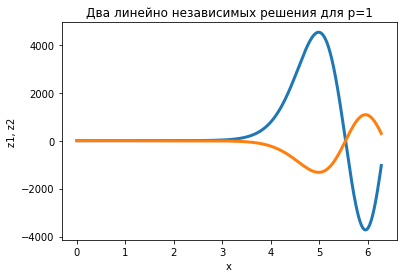

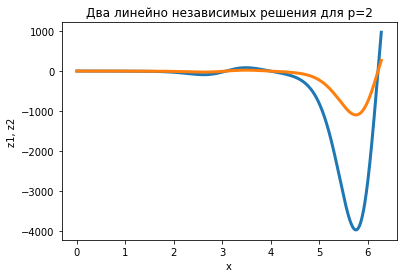

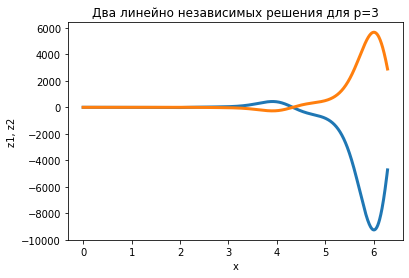

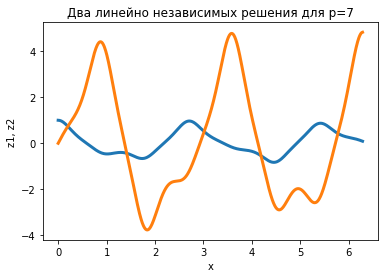

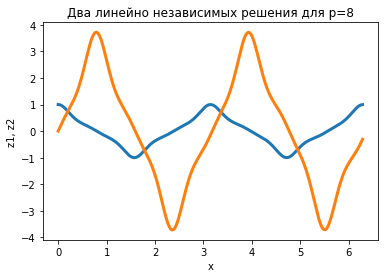

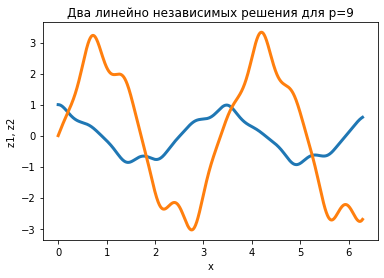

In [8]:
for p in [1, 2, 3, 7, 8, 9]:
  
    #зададим сетку
    t = np.linspace(0,2*np.pi,1000)

    #создадим график
    fig, ax = plt.subplots()
    ax.set_xlabel('x')
    ax.set_ylabel('z1, z2')
    ax.set_title('Два линейно независимых решения для p='+str(p))

    #Начальные условия
    z0 = [[1, 0], [0, 4]]

    #Первое решение с начальными условиями 1 0
    [z_11,z_21]=odeint(deffur, z0[0], t, full_output=False).T
    ax.plot(t, z_11, linewidth=3)

    #Второе решение с начальными условиями 0 4
    [z_12,z_22]=odeint(deffur, z0[1], t, full_output=False).T
    ax.plot(t, z_12, linewidth=3)

# Задача №6.2

Выберем 11 точек для дальнейшей интерполяции

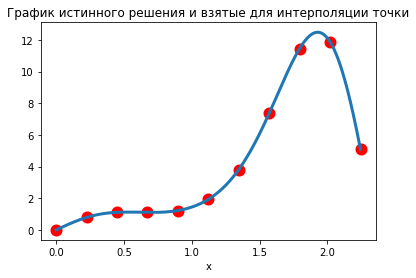

In [9]:
p = 14/5
t = np.linspace(0,2*np.pi/p,5000)
x_points = np.linspace(0, 2*np.pi/p, 11)
[z_2n,z_2nn]=odeint(deffur, z0[1], x_points, full_output=False).T
[z_11,z_21]=odeint(deffur, z0[1], t, full_output=False).T
fig, ax = plt.subplots()
ax.plot(t, z_11, linewidth=3)
ax.set_xlabel('x')
ax.set_title('График истинного решения и взятые для интерполяции точки')
ax.scatter(x_points, z_2n, linewidth=6, c='r')

Зададим и отрисуем сплайн и оригинальный график

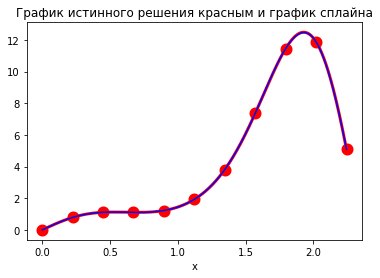

In [10]:
s = Interpolation(t, x_points, z_2n).splain_interp(4, -43.96918281)

fig, ax = plt.subplots()
ax.plot(t, z_11, linewidth=3, c='r')
ax.set_xlabel('x')
ax.set_title('График истинного решения красным и график сплайна')
ax.scatter(x_points, z_2n, linewidth=6, c='r')
ax.plot(t, s, c='b')

Посмотрим на их ошибку

Text(0.5, 1.0, 'Ошибка сплайна')

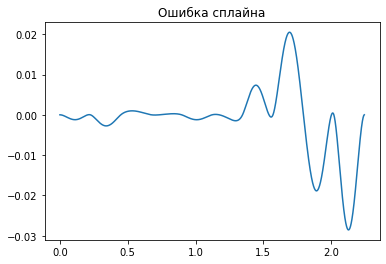

In [11]:
s_eror = s-z_11
fig, ax = plt.subplots()
ax.plot(t, s_eror)
ax.set_title('Ошибка сплайна')

# Задача №6.3

Сделаем то же задание для первой производной того же решения

Сделаем сплайн и посмотрим на его рисунок

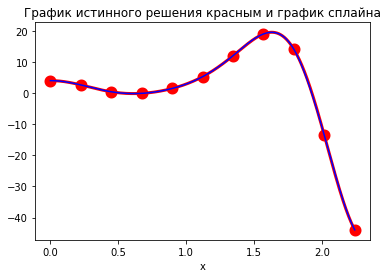

In [12]:
s = Interpolation(t, x_points, z_2nn).splain_interp(-0.0143644, -81.454982)

fig, ax = plt.subplots()
ax.plot(t, z_21, linewidth=3, c='r')
ax.set_xlabel('x')
ax.set_title('График истинного решения красным и график сплайна')
ax.scatter(x_points, z_2nn, linewidth=6, c='r')
ax.plot(t, s, c='b')

Посмотрим на ошибку сплайна

Text(0.5, 1.0, 'Ошибка сплайна')

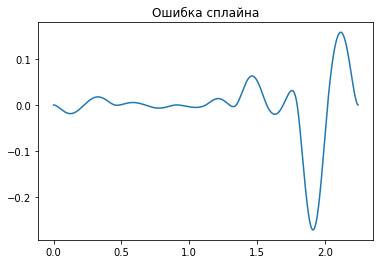

In [13]:
s_eror = s-z_21
fig, ax = plt.subplots()
ax.plot(t, s_eror)
ax.set_title('Ошибка сплайна')

Теперь рассчитаем вторую производную данного решения 

и выделим 11 точек для интерполяции

In [14]:
dz2_dt = np.array([])
x_points = np.array([])
y_points = np.array([])
for i in range(z_21.shape[0]-1):
    dz2_dt = np.append(dz2_dt, (z_21[i+1]-z_21[i])/(t[i+1]-t[i]))
    if i % ((z_21.shape[0]//11)+1) == 0:
        x_points = np.append(x_points, t[i])
        y_points = np.append(y_points, (z_21[i+1]-z_21[i])/(t[i+1]-t[i]))
x = t[t<=x_points[-1:]]
dz2_dt = dz2_dt[:4551]

Визуализируем полученный результат

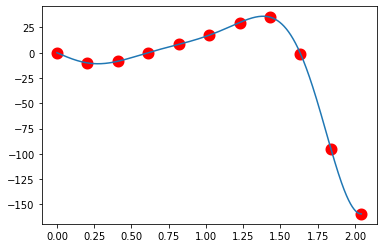

In [15]:
fig, ax = plt.subplots()
ax.plot(x, dz2_dt)
ax.scatter(x_points, y_points, linewidths = 6, c='r')

Создадим сплайн

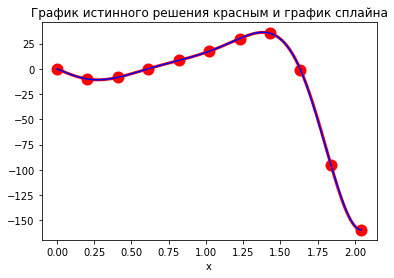

In [16]:
s = Interpolation(x, x_points, y_points).splain_interp(-63.999642, -2.861560) 
fig, ax = plt.subplots()
ax.plot(x, dz2_dt, linewidth=3, c='r')
ax.set_xlabel('x')
ax.set_title('График истинного решения красным и график сплайна')
ax.scatter(x_points, y_points, linewidth=6, c='r')
ax.plot(x, s, c='b')

посмотрим на его ошибку

Text(0.5, 1.0, 'Ошибка сплайна')

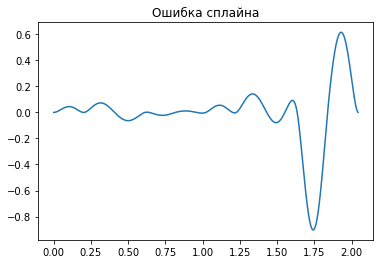

In [17]:
s_eror = s-dz2_dt
fig, ax = plt.subplots()
ax.plot(x, s_eror)
ax.set_title('Ошибка сплайна')

Посчитаем производную сплайна

In [18]:
x_points = np.linspace(0, 2*np.pi/p, 11)
s = Interpolation(t, x_points, z_2n).splain_interp(4, -43.96918281)

ds_dt = np.array([])
x_points = np.array([])
y_points = np.array([])
for i in range(s.shape[0]-1):
    ds_dt = np.append(ds_dt, (s[i+1]-s[i])/(t[i+1]-t[i]))
    if i % ((s.shape[0]//11)+1) == 0:
        x_points = np.append(x_points, t[i])
        y_points = np.append(y_points, (s[i+1]-s[i])/(t[i+1]-t[i]))
x = t[t<=x_points[-1:]]
ds_dt = ds_dt[:4551]

Приблизим сплайном его производную

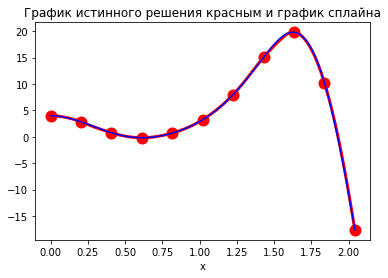

In [19]:
s = Interpolation(x, x_points, y_points).splain_interp(-0.713899, -165.037629) 
fig, ax = plt.subplots()
ax.plot(x, ds_dt, linewidth=3, c='r')
ax.set_xlabel('x')
ax.set_title('График истинного решения красным и график сплайна')
ax.scatter(x_points, y_points, linewidth=6, c='r')
ax.plot(x, s, c='b')

Посмотрим на полученную ошибку

Text(0.5, 1.0, 'Ошибка сплайна')

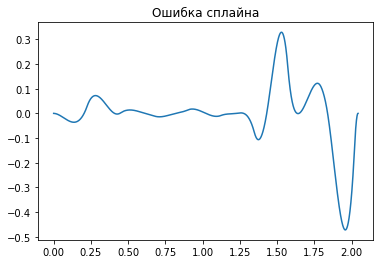

In [20]:
s_eror = s-ds_dt
fig, ax = plt.subplots()
ax.plot(x, s_eror)
ax.set_title('Ошибка сплайна')

Теперь посмотрим вторую производную сплайна

In [21]:
ds2_dt = np.array([])
x_points = np.array([])
y_points = np.array([])
for i in range(ds_dt.shape[0]-1):
    ds2_dt = np.append(ds2_dt, (ds_dt[i+1]-ds_dt[i])/(x[i+1]-x[i]))
    if i % ((ds_dt.shape[0]//11)+1) == 0:
        x_points = np.append(x_points, x[i])
        y_points = np.append(y_points, (ds_dt[i+1]-ds_dt[i])/(x[i+1]-x[i]))

Приблизим её

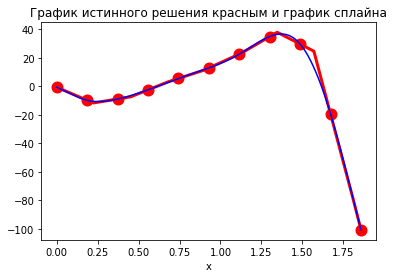

In [22]:
x = x[x<=x_points[-1:]]
ds2_dt = ds2_dt[:4141]
s = Interpolation(x, x_points, y_points).splain_interp(-49.214710, -448.504335) 
fig, ax = plt.subplots()
ax.plot(x, ds2_dt, linewidth=3, c='r')
ax.set_xlabel('x')
ax.set_title('График истинного решения красным и график сплайна')
ax.scatter(x_points, y_points, linewidth=6, c='r')
ax.plot(x, s, c='b')

Посмотрим на ошибку она сильно возросла, поскольку мы приближаем вторую 

производную кубического сплайна, которая линейна, кубическим сплайном, 

и эти функции имеют разную степень

Text(0.5, 1.0, 'Ошибка сплайна')

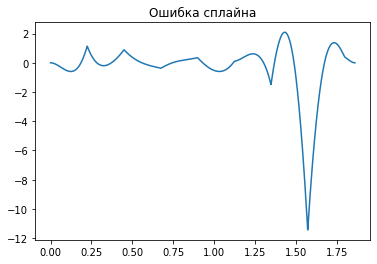

In [23]:
s_eror = s-ds2_dt
fig, ax = plt.subplots()
ax.plot(x, s_eror)
ax.set_title('Ошибка сплайна')

# Задача №6.4

Зададим точки в которых будем интерполировать

In [24]:
x_points = np.linspace(0, 2*np.pi/p, 11)
[z_2n,z_2nn]=odeint(deffur, z0[1], x_points, full_output=False).T
[z_11,z_21]=odeint(deffur, z0[1], t, full_output=False).T

Применим интерполяционный многочлен Лагранжа, и визуализируем результат

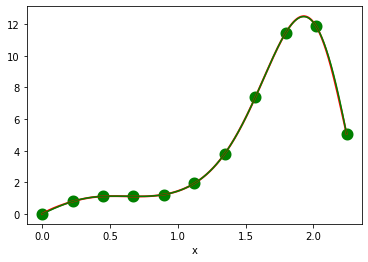

In [25]:
lagrange = Interpolation(t, x_points, z_2n).L_polinomial()
fig, ax = plt.subplots()
ax.plot(t, lagrange, c='r', linewidth=2)
ax.plot(t, z_11, c='g')
ax.set_xlabel('x')
ax.scatter(x_points, z_2n, linewidth=6, c='g')

Нарисуем график ошибки

Text(0.5, 1.0, 'Ошибка интерполяционного многочлена Лагранжа')

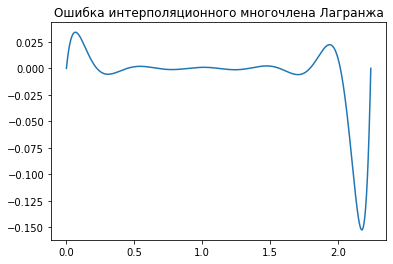

In [26]:
L_eror = lagrange-z_11
fig, ax = plt.subplots()
ax.plot(t, L_eror)
ax.set_title('Ошибка интерполяционного многочлена Лагранжа')

Посмотрим как он приблизит производную решения

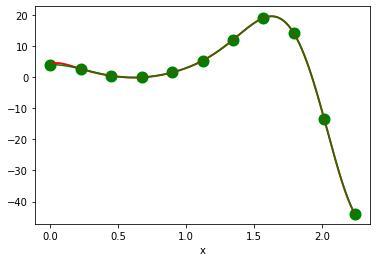

In [27]:
lagrange = Interpolation(t, x_points, z_2nn).L_polinomial()
fig, ax = plt.subplots()
ax.plot(t, lagrange, c='r', linewidth=2)
ax.plot(t, z_21, c='g')
ax.set_xlabel('x')
ax.scatter(x_points, z_2nn, linewidth=6, c='g')

Text(0.5, 1.0, 'Ошибка интерполяционного многочлена Лагранжа')

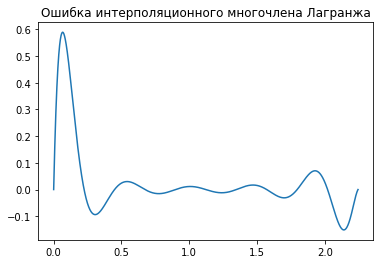

In [28]:
L_eror = lagrange-z_21
fig, ax = plt.subplots()
ax.plot(t, L_eror)
ax.set_title('Ошибка интерполяционного многочлена Лагранжа')

Применим интерполяцию ко второй производной решения

In [29]:
dz2_dt = np.array([])
x_points = np.array([])
y_points = np.array([])
for i in range(z_21.shape[0]-1):
    dz2_dt = np.append(dz2_dt, (z_21[i+1]-z_21[i])/(t[i+1]-t[i]))
    if i % ((z_21.shape[0]//11)+1) == 0:
        x_points = np.append(x_points, t[i])
        y_points = np.append(y_points, (z_21[i+1]-z_21[i])/(t[i+1]-t[i]))
x = t[t<=x_points[-1:]]
dz2_dt = dz2_dt[:4551]

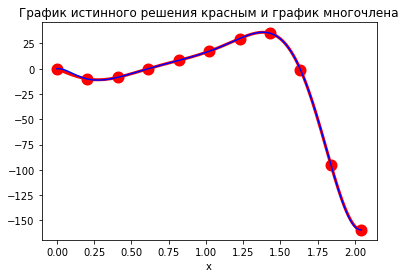

In [30]:
s = Interpolation(x, x_points, y_points).L_polinomial()
fig, ax = plt.subplots()
ax.plot(x, dz2_dt, linewidth=3, c='r')
ax.set_xlabel('x')
ax.set_title('График истинного решения красным и график многочлена')
ax.scatter(x_points, y_points, linewidth=6, c='r')
ax.plot(x, s, c='b')

Text(0.5, 1.0, 'Ошибка')

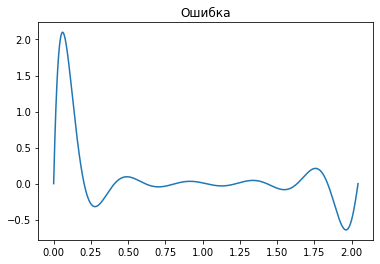

In [31]:
s_eror = s-dz2_dt
fig, ax = plt.subplots()
ax.plot(x, s_eror)
ax.set_title('Ошибка')

Используем интерполяционный многочлен Лагранжа для производной сплайна

In [32]:
x_points = np.linspace(0, 2*np.pi/p, 11)
s = Interpolation(t, x_points, z_2n).splain_interp(4, -43.96918281)

ds_dt = np.array([])
x_points = np.array([])
y_points = np.array([])
for i in range(s.shape[0]-1):
    ds_dt = np.append(ds_dt, (s[i+1]-s[i])/(t[i+1]-t[i]))
    if i % ((s.shape[0]//11)+1) == 0:
        x_points = np.append(x_points, t[i])
        y_points = np.append(y_points, (s[i+1]-s[i])/(t[i+1]-t[i]))
x = t[t<=x_points[-1:]]
ds_dt = ds_dt[:4551]

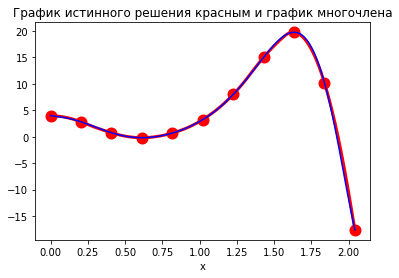

In [33]:
lagrange = Interpolation(x, x_points, y_points).L_polinomial()
fig, ax = plt.subplots()
ax.plot(x, ds_dt, linewidth=3, c='r')
ax.set_xlabel('x')
ax.set_title('График истинного решения красным и график многочлена')
ax.scatter(x_points, y_points, linewidth=6, c='r')
ax.plot(x, lagrange, c='b')

Text(0.5, 1.0, 'Ошибка')

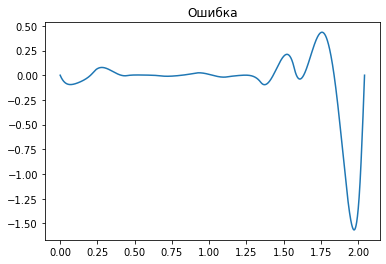

In [34]:
L_eror = lagrange-ds_dt
fig, ax = plt.subplots()
ax.plot(x, L_eror)
ax.set_title('Ошибка')

Построим многочлен Лагранжа по точкам из 

второй производной кубического сплайна

In [35]:
ds2_dt = np.array([])
x_points = np.array([])
y_points = np.array([])
for i in range(ds_dt.shape[0]-1):
    ds2_dt = np.append(ds2_dt, (ds_dt[i+1]-ds_dt[i])/(x[i+1]-x[i]))
    if i % ((ds_dt.shape[0]//11)+1) == 0:
        x_points = np.append(x_points, x[i])
        y_points = np.append(y_points, (ds_dt[i+1]-ds_dt[i])/(x[i+1]-x[i]))

По той же причине, что и со сплайном ошибка растет

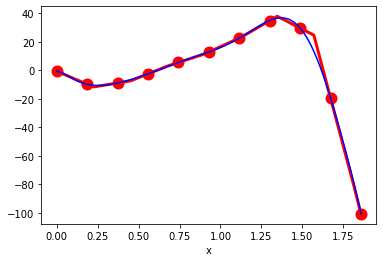

In [36]:
x = x[x<=x_points[-1:]]
ds2_dt = ds2_dt[:4141]
lagrange = Interpolation(x, x_points, y_points).L_polinomial()
fig, ax = plt.subplots()
ax.plot(x, ds2_dt, linewidth=3, c='r')
ax.set_xlabel('x')
ax.scatter(x_points, y_points, linewidth=6, c='r')
ax.plot(x, lagrange, c='b')

Text(0.5, 1.0, 'Ошибка')

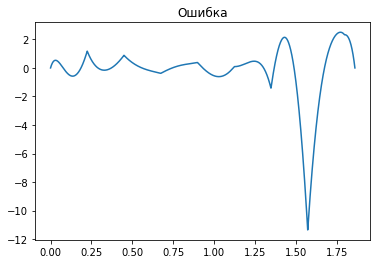

In [37]:
L_eror = lagrange-ds2_dt
fig, ax = plt.subplots()
ax.plot(x, L_eror)
ax.set_title('Ошибка')

ФИО: Петров Георгий Алексеевич
-------------------------------           
Группа на курсе: 2                       
Номер в списке: 14                       
Почта: gapetrov_1@edu.hse.ru